In [24]:
import numpy as np
import torch
from Utils import visualize_batch
import matplotlib.pyplot as plt
from DataSets import ShmootDataSet256
import imageio
import torchvision.transforms.functional as F

plt.rcParams["figure.figsize"] = (15, 15)

device = 'cpu'

In [15]:
model = torch.load('checkpoints/256final/T256_hLR_stylelayers_7500.pt').to(device)
model.device = 'cpu'
# setattr(model.decoder, 'first_fmap_size', 128//8)  # a small fix that is required after changing the model

model.requires_grad = False
model = model.eval()

latent_size = 128

# Random Sampling

In [ ]:
samples = model.sample(15)
visualize_batch(samples, im_per_row=5)

## lower variance sampling:

In [ ]:
for std in [0.05, 0.1, 0.5, 5, 25, 100]:
    print("std:", std)
    z = torch.normal(0 * torch.ones(4,latent_size), std*torch.ones(4,latent_size)).to(device)
    samples = model.decoder(z)
    visualize_batch(samples)

# Systematic sampling
## vector of the same constant

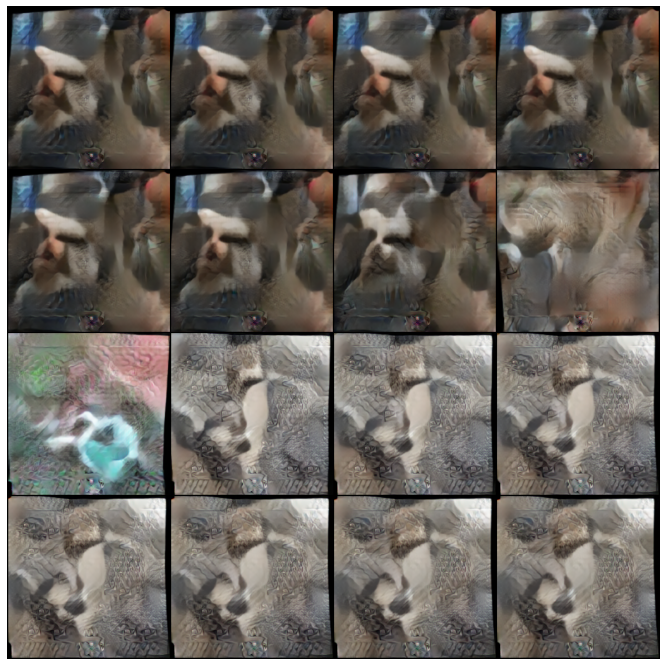

In [21]:
# z = torch.normal(0 * torch.ones(2,400), 1*torch.ones(2,400)).to(device)
z = [(c * torch.ones(1, latent_size)).to(device) for c in torch.linspace(-2, 2, 16).view(16, 1, 1)]
z = torch.stack(z)
samples = model.decoder(z)
visualize_batch(samples)

## vector of the same constant tiled negatively and positively
[1, -1, 1, -1 ...]

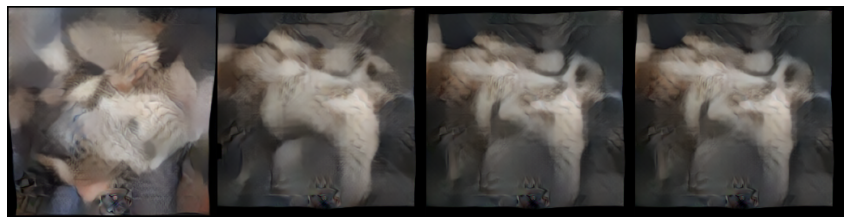

In [30]:
z = [torch.tensor([c, -c]*(latent_size//2)).to(device) for c in[0.1, 1, 10, 25]]
z = torch.stack(z)
samples = model.decoder(z)
visualize_batch(samples)

## changing one element

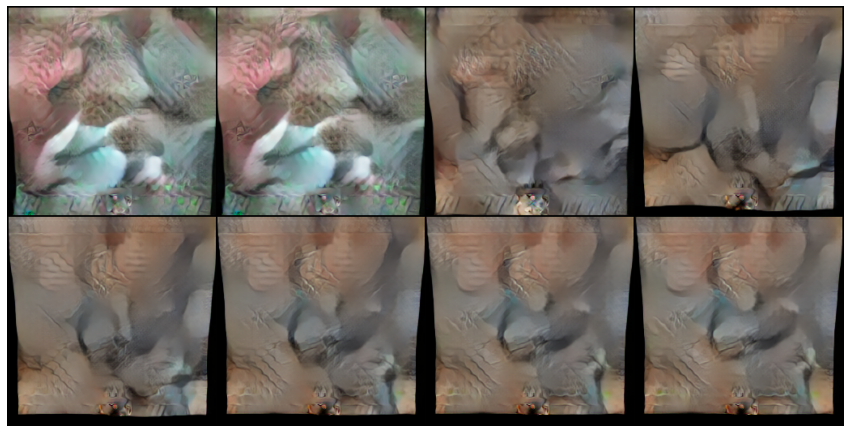

In [40]:
z = torch.zeros(latent_size).to(device)
z_list = [z]
for i in range(7):
    z_list.append(z.clone())
    z_list[-1][42] += i*10
samples = model.decoder(torch.stack(z_list))
visualize_batch(samples)

## Changing Four Elements

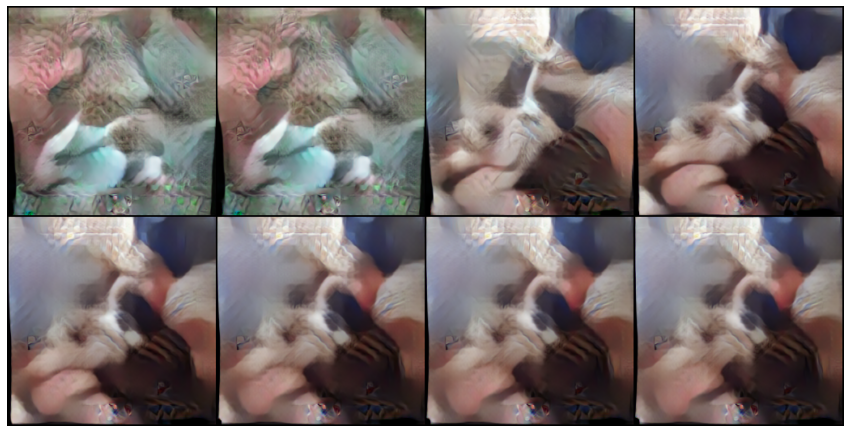

In [39]:
z = torch.zeros(latent_size).to(device)
z_list = [z]
for i in range(7):
    z_list.append(z.clone())
    z_list[-1][20:24] += i
samples = model.decoder(torch.stack(z_list))
visualize_batch(samples)

# Interpolating between two images

In [53]:
def interpolate(im1_id, im2_id, steps=32, fps=24):
    shmoot_dataset = ShmootDataSet256(augment=False)
    im1 = shmoot_dataset[im1_id].unsqueeze(0).to(device)
    im2 = shmoot_dataset[im2_id].unsqueeze(0).to(device)

    _, mu1, _ = model.encoder(im1)
    _, mu2, _ = model.encoder(im2)
    interp_weight = torch.linspace(0, 1, steps).view(steps, 1).to(device)

    z = (1-interp_weight)*mu1 + interp_weight*mu2

    images = model.decoder(z).detach().cpu()
    images = [F.to_pil_image(im) for im in images]
    # keep first image and last image for a few frames
    images = [images[0]]*4 + images + [images[-1]]*4
    images += reversed(images)
    imageio.mimsave(f'assets/interpolation_{im1_id}_{im2_id}.gif', images, fps=fps)

In [68]:
imagees_pairs = [(1, 2), (16, 996), (24, 42), (500, 600),]
for pair in imagees_pairs:
    interpolate(*pair)

# Sampling from $P(z|x)$ for all images
gonna take some time (one full epoch)

In [77]:
shmoot_dataset = ShmootDataSet256(augment=False)
dl = torch.utils.data.DataLoader(shmoot_dataset, batch_size=16)

sample_count = 0
mu_avg = torch.zeros(latent_size)
mu_avg.requires_grad = False
std_avg = torch.zeros(latent_size)
std_avg.requires_grad = False

with torch.no_grad():
    for batch in dl:
        batch = batch.to(device)
        _, mu, log_var = model.encoder(batch)

        sample_count += batch.shape[0]
        mu_avg += torch.sum(mu, dim=0)
        std_avg += torch.sum(torch.exp(0.5*log_var), dim=0)

    mu_avg = mu_avg / sample_count
    std_avg = std_avg / sample_count

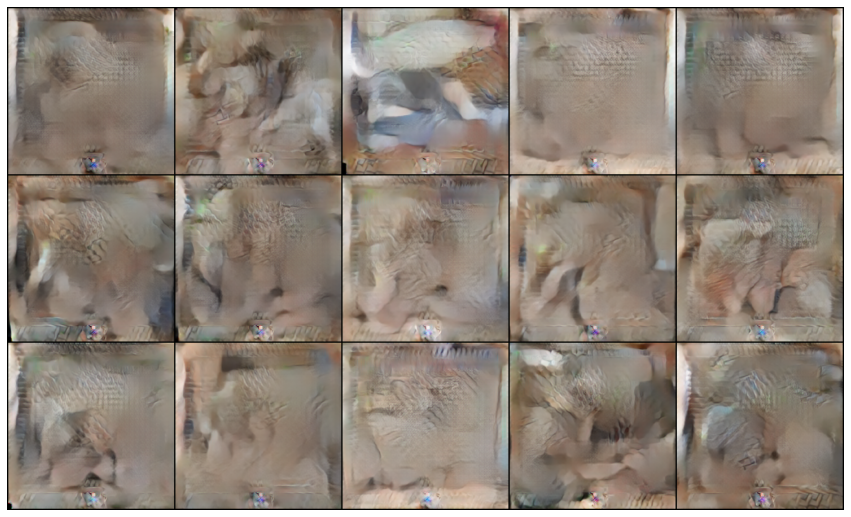

In [78]:
z = torch.randn((15, latent_size)).to(device)
z = z * std_avg + mu_avg

samples = model.decoder(z)
visualize_batch(samples, im_per_row=5)

A trick that ampirically worked better after looking at tge values of mu and std:

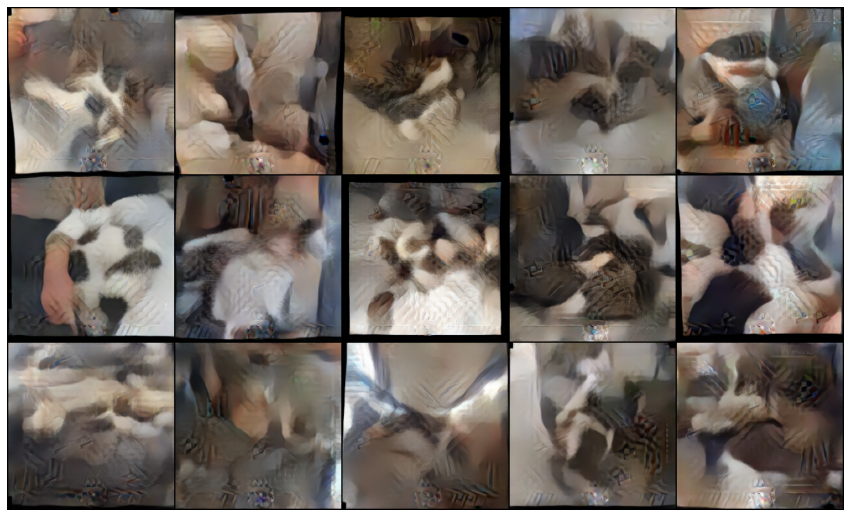

In [67]:
std_avg[std_avg<0.5] = 1
std_avg[std_avg>1.5] = 1

z = torch.randn((15, latent_size)).to(device)
z = z * std_avg + mu_avg

samples = model.decoder(z)
visualize_batch(samples, im_per_row=5)